# TP 2
# Construire ses propres simulations

### Objectifs

Utiliser ATOM tel quel sans écrire de code. Manipuler / Vérifier les
traces

Documentation Atom : http://atom.univ-lille1.fr/AtomDoc.html  
Documentation R : https://www.r-project.org/manuals.html

**Connaissances préalables** : Un peu de Python

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import random
FILES = "files/"

from atom import *
from data_processing import *
import statsmodels.tsa.stattools as stats
plt.rcParams['figure.figsize'] = (15,10)

## 1 Ré-écrire un équivalent de Generate

_pas équivalent à Java_



## 2 Des ZIT plus évolués

Par défaut, les ZIT décident aléatoirement de déposer un ordre coté Ask ou Bid aléatoirement. Il est néanmoins possible de passer
en paramètre les deux probabilités d’envoyer un Bid ou un ask :

`t = ZITTrader(m, q_min=1,q_max=10,p_min=100, p_max=999, pb_ask=0.2, pb_bid=0.3)`

crée un agent avec qui ne parle que dans 50% des cas, et qui, quand il parle, décide d’envoyer plus de BID (30%) que
de ASK (20%), sur une quantité entre 1 et 10 et un prix entre 100 et 999.

**1. Créez un marché Imbalance qui invoque uniquement 2 agents, l’un avec 20% et 30% (resp Ask et Bid) et
l’autre avec 40% et 50% (resp Ask et Bid), sur une période continue de 1000 tours de parole.**

In [2]:
file = open('trace.dat', 'w')
m = Market(['Apple'],out=file)
t1 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.2, pb_bid=0.3)
t2 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.4, pb_bid=0.5)
m.add_trader(t1)
m.add_trader(t2)
for i in range(1000):
    m.run_once()
m.print_state()

traders_id = []
for trader in m.traders:
    traders_id.append(trader.trader_id)
    
file.close()

**2. Comment vérifier dans le fichier résultat les statistiques de départ ?**

In [3]:
zit1 = "ZIT "+str(traders_id[0])
file = open('trace.dat','r')
line = file.readline()
tot=0
bid=0
ask=0
while(line!=""):
    if ("LimitOrder;Apple;"+zit1 in line and line[0]!='#'):
        if (line.split(";")[3])=="BID":
            bid+=1
        else:
            ask+=1
        tot+=1
    line = file.readline()
print("Agent {} a envoyé {} ordres soit sur {}% des ticks".format(zit1,tot,tot/10))
print("composés de {} asks (sur {}% des ticks) et {} ({}% des ticks) bids".format(ask,ask/10,bid,bid/10))

Agent ZIT 1 a envoyé 493 ordres soit sur 49.3% des ticks
composés de 227 asks (sur 22.7% des ticks) et 266 (26.6% des ticks) bids


## 3 Tests de rapidité



**1. Créer une simulation de marché à un seul asset et 1000 agents ZIT, qui effectue  1000 tours de parole (donc 1
million d’ordres exécutés par le marché).**  
_100 millions = bcp trop long en python_

In [4]:
import time
t = time.time()
m = Market(['Apple'],trace="")
#m.generate(1000, 1000)
print(int((time.time()-t)),"s")

0 s


## 4 De la difficulté à ne pas se ruiner

Le ModerateAgent est un ZIT qui attend l’exécution totale de l’ordre envoyé pour en envoyer un nouveau.
Le IntelligentAgent est un ModerateAgent qui en plus, vérifie toujours qu’il a le cash suffisant pour ne pas passer en
valeurs négatives.  

**1. Lancer un marché qui vérifie le bon fonctionnement du ModerateAgent : il contiendra 1 Moderate
et 10 ZIT qui s’exécutent durant 1000 tours.  
En fin d’expérience, on affichera son cash, ses invests et la valuation de son portefeuille final. Vérifiez dans la trace d’exécution le bon fonctionnement de l’agent Moderate.**

In [5]:
class ModerateTrader(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "MOD " + super().__str__()
    def decide_order(self, market, asset):
        # On compte le nombre d'ordres placés dans les orderbooks par cet agent...
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK':
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, 9))
            elif direction == 'BID':
                price = random.randint(1000, 9999)
                # On n'achète pas pour un volume > au cash qu'on a.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, 9))
        return None # Dans tous les autres cas, on ne place pas d'ordre.

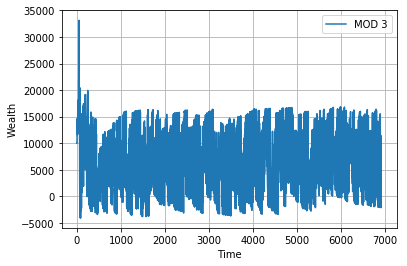

Avec 10000  de cash au départ
Wealth : 3494 (peut être négatif)
Profit : -6506


In [6]:
file = open('trace_moderate.dat', 'w')
m = Market(['Apple'],out=file)
cash = 10000
moderate = ModerateTrader(m,cash=cash) # obligé d'avoir du cash au départ
m.add_trader(moderate)

for i in range(10):
    t = ZITTrader(m,cash=cash)
    m.add_trader(t)

for i in range(1000):
    m.run_once()
m.print_state()   
file.close()

Wealths = extract_wealths('trace_moderate.dat')
for agent in Wealths.keys():
    if "MOD" in agent:
        magent = agent
T, W = Wealths[magent]
plt.plot(W, '-', label=magent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()
print("Avec",cash," de cash au départ")
print("Wealth :",W[-1],"(peut être négatif)")
print("Profit :",W[-1]-cash)

**2. Lancer un marché qui vérifie le bon fonctionnement du IntelligentAgent : il contiendra
1 Intelligent et 10 ZIT qui s’exécutent durant 1000 tours. En fin d’expérience, on affichera son cash, ses invests et la
valuation de son portefeuille final. Vérifiez dans la trace d’exécution le bon fonctionnement de l’agent Intelligent**

In [7]:
class IntelligentTrader(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "INT " + super().__str__()
    def decide_order(self, market, asset):
        # On compte le nombre d'ordres placés dans les orderbooks par cet agent...
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK' and self.assets[asset] > 0: # Si on a quantité > 0 d'actions pour cet asset...
                # On ne vend pas une quantité d'actions > à celle qu'on a.
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, min(self.assets[asset], 9)))
            elif direction == 'BID' and self.cash >= 1000: # Pour acheter, il faut de l'argent...
                price = random.randint(1000, min(self.cash, 9999))
                # On n'achète pas pour un volume > au cash qu'on a.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, min(self.cash//price, 9)))
        return None # Dans tous les autres cas, on ne place pas d'ordre.

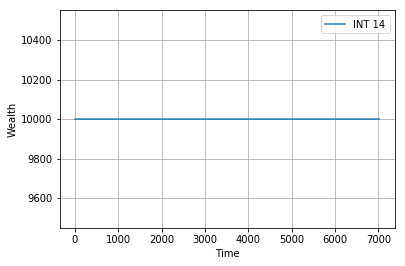

Avec 10000  de cash au départ
Wealth : 10000 (ne peut être négatif)
Profit : 0


In [8]:
file = open('trace_intelligent.dat', 'w')
m = Market(['Apple'],out=file)
cash = 10000
intelligent = IntelligentTrader(m,cash=cash) # obligé d'avoir du cash au départ
m.add_trader(intelligent)

for i in range(10):
    t = ZITTrader(m,cash=cash)
    m.add_trader(t)

for i in range(1000):
    m.run_once()
m.print_state()   
file.close()

Wealths = extract_wealths('trace_intelligent.dat')
for agent in Wealths.keys():
    if "INT" in agent:
        iagent = agent
T, W = Wealths[iagent]
plt.plot(W, '-', label=iagent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()
print("Avec",cash," de cash au départ")
print("Wealth :",W[-1],"(ne peut être négatif)")
print("Profit :",W[-1]-cash)

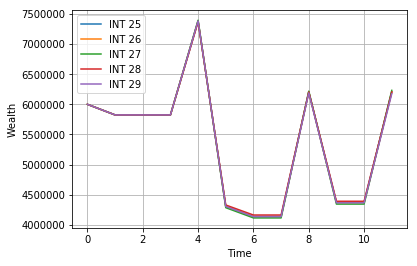

Tout est bloqué très rapidement. Chacun attend que son ordre soit exécuté -> deadlock


In [9]:
file = open('trace_all_intelligent.dat', 'w')
m = Market(['Apple'],out=file)
cash = 1000000
for i in range(5):
    t = IntelligentTrader(m,initial_assets=[1000],cash=cash)
    m.add_trader(t)

for i in range(1000):
    m.run_once()
m.print_state()   
file.close()

Wealths = extract_wealths('trace_all_intelligent.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

print("Tout est bloqué très rapidement. Chacun attend que son ordre soit exécuté -> deadlock")